In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from multiprocessing import Pool
from lampe.data import JointLoader
from itertools import islice
from tqdm import tqdm
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import coverage_plot
import mrcfile
import umap

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors
from cryo_sbi.utils.estimator_utils import sample_posterior, compute_latent_repr

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_name = '6wxb_nma'    # File name 
data_dir = "../experiments/6wxb/"
num_samples_stats = 20000           # Number of simulations for computing posterior stats
num_samples_SBC = 10000             # Number of simulations for SBC
num_posterior_samples_SBC = 4096    # Number of posterior samples for each SBC simulation
num_samples_posterior = 50000       # Number of samples to draw from posterior
batch_size_sampling = 100           # Batch size for sampling posterior
num_workers = 24                    # Number of CPU cores
device = 'cuda'                     # Device for computations
save_figures = False

## Load cryo-em simulator and posterior with correct config

In [3]:
cryosbi = CryoEmSimulator(data_dir + "image_params_training.json")

../data/protein_models/6wxb_models.npy


In [4]:
train_config = json.load(open(data_dir + "resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(data_dir + "posterior_6wxb.estimator"))
estimator.cuda()
estimator.eval();

In [7]:
indices = torch.tensor(np.arange(0, cryosbi.max_index + 1, 5), dtype=float).reshape(-1, 1)
indices = torch.arange(0, 100, 5, dtype=torch.float)
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

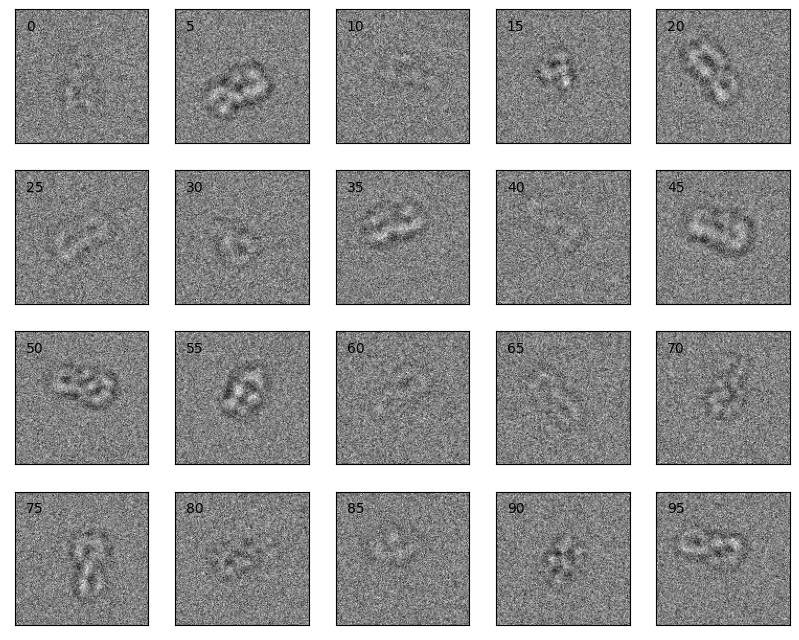

In [8]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[idx], vmax=4, vmin=-4, cmap='binary')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(10, 20, str(int(indices[idx].item())))
#plt.savefig('../experiments/6wxb/results/plots/6wxb_examples.pdf')

In [119]:
samples = sample_posterior(estimator, images, num_samples=10000, device='cuda')

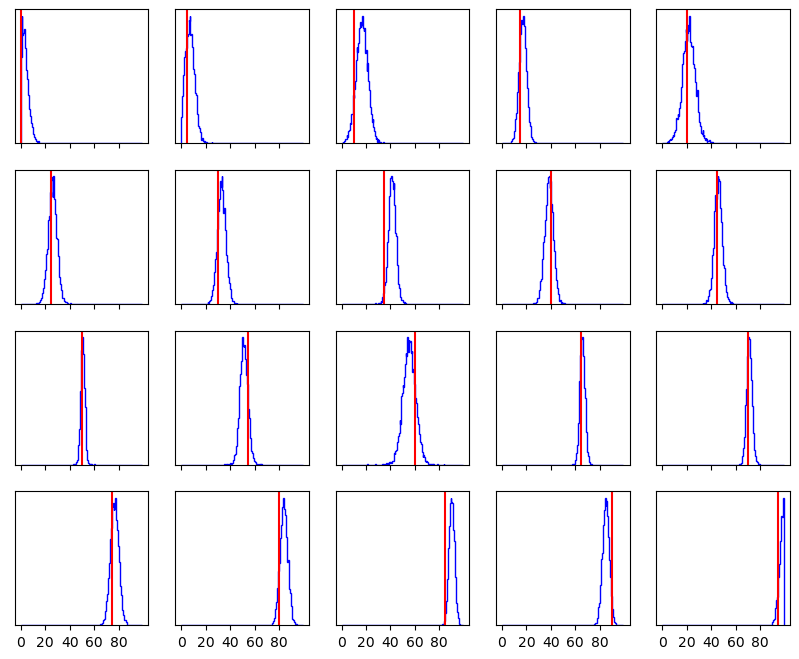

In [120]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(samples[:, idx].flatten().numpy(), bins=np.arange(0, 100, 0.5), histtype="step", color="blue", label="all")
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))
    ax.axvline(indices[idx], color='red')
#plt.savefig('../experiments/6wxb/results/plots/torsion_nma.pdf', dpi=300)

In [121]:
import torchvision.transforms as transforms

class NormalizeIndividual():
    def __init__(self) -> None:
        pass

    def __call__(self, images):
        mean = images.mean(dim=[1, 2])
        std = images.std(dim=[1, 2])
        return transforms.functional.normalize(
            images,
            mean=mean, 
            std=std
        )

    
class MRCtoTensor():
    def __init__(self) -> None:
        pass

    def __call__(self, image_path):
        assert isinstance(image_path, str), 'image path needs to be a string'
        with mrcfile.open(image_path) as mrc:
            image = mrc.data
        return torch.from_numpy(image)
    


transform = transforms.Compose([
    MRCtoTensor(),
    transforms.Resize(size=(128, 128)),
    NormalizeIndividual()
])

In [122]:
img_file = '../../6wxb_test_particles/10532/data/03_Refined_Particles/P30_J363_particles/J342/localmotioncorrected/FoilHole_24136295_Data_24136362_24136364_20200224_020513_Fractions_particles_local_aligned.mrc'

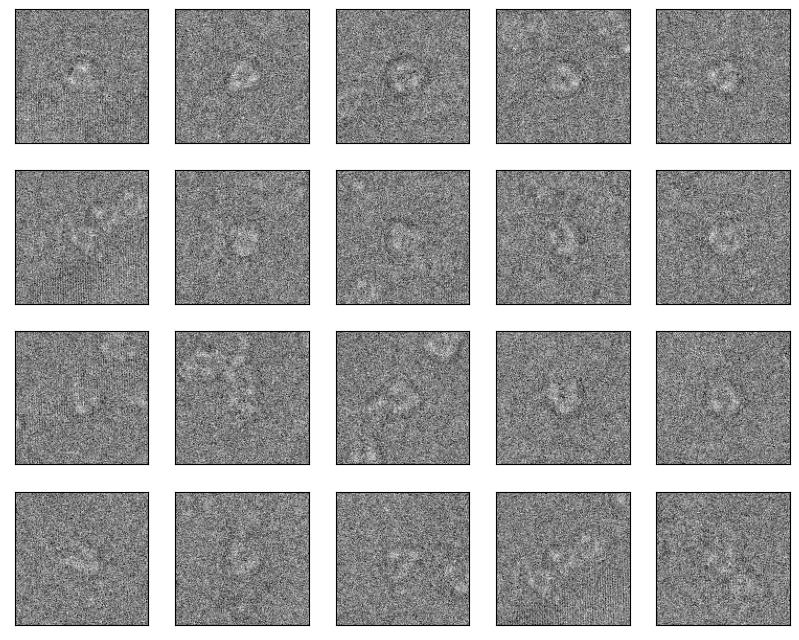

In [123]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(transform(img_file)[i+20], vmax=4, vmin=-4, cmap='binary')
    ax.set_yticks([])
    ax.set_xticks([])

In [124]:
particles_transfomed = transform(img_file)

In [131]:
indices = priors.get_uniform_prior_1d(cryosbi.max_index).sample((1000,))
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [132]:
syntetic_particles_latent = compute_latent_repr(estimator, images, batch_size=100, device='cuda')
particles_latent = compute_latent_repr(estimator, particles_transfomed, batch_size=100, device='cuda')
cat_latent_samples = torch.cat((syntetic_particles_latent, particles_latent), dim=0)
labels_latent = torch.cat((torch.ones((len(indices),)), torch.zeros((161,))), dim=0)

In [133]:
reducer = umap.UMAP(metric='euclidean', n_components=2,  n_neighbors=50)
embedding = reducer.fit_transform(cat_latent_samples.numpy())

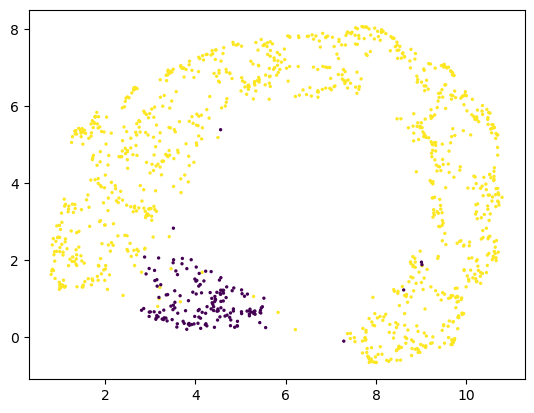

In [138]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, c=labels_latent)

Text(0.5, 1.0, 'Syntehtic particle')

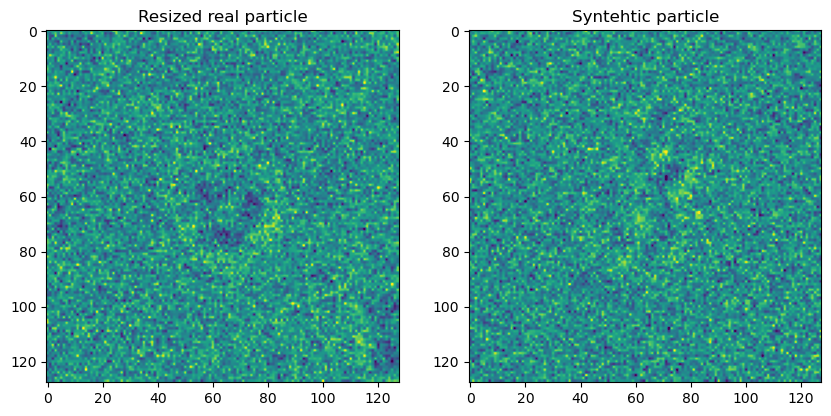

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(particles_transfomed[1], vmax=3, vmin=-3)
axes[0].set_title('Resized real particle')
axes[1].imshow(images[2], vmax=3, vmin=-3)
axes[1].set_title('Syntehtic particle')
#fig.savefig('../experiments/6wxb/results/plots/comparison_particles.pdf', dpi=400)